In [ ]:
# these are different parts of huggingface
!pip install transformers
!pip install datasets
!pip install seqeval

import pandas as pd

# Intoduction to NLP

We've been working with images so far. It's time we try something new.

NLP (Natural Language Processing) is a subfield of AI concerned with text processing and analysis. Typical NLP tasks are:
*   Text generation
*   Text classification
*   Token classification (i.e. check if a certain word belongs to a certain group (nouns, movie names, technical jargon, etc.))
*   Summarization
*   Keyword retrieval
*   and many others...

# Named entity recognition

**NER** (Named Entity Recognition) is a subtask of **Token classification**. It's purpose it to recognize named entities of certain type (names, locations, python packages etc.) in a text.

### Consider this example:
Say we want to extract all locations from a text. This is our test phrase:
```
London is the capital of Great Britain.
```
First, we split it into list of **tokens** (usually individual words). In other words, we **tokenize** it:
```
["london", "is", "the", "capital", "of", "great", "britain", "."]
```
Then we apply our **NER-model** (you'll be training one in this notebook!). Result will look something like this (each token corresponds to a number):
```
[1, 0, 0, 0, 0, 1, 2, 0]
```
where i-th number is the index of a **label** of the i-th token.
Labels and their IDs are pre-defined by you (the one creating the model/dataset) and in this example look like this:
```
{
  "O": 0,
  "B-LOCATION": 1,
  "I-LOCATION": 2
}
```

This is the widely-used IOB2 format. (https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging))  
**"O"** denotes something that has no label of our interest.  
Tokens starting with **"B-"** indicate the **b**egging of an entity.  
Tokens starting with **"I-"** indicate that the token is **i**nside an entity.

If you are confused, this is the result of applying the NER model in a more human-readable form:
```
[
  ("london",  "B-LOCATION"),
  ("is",      "O"),
  ("the",     "O"),
  ("capital", "O"),
  ("of",      "O"),
  ("great",   "B-LOCATION"),
  ("britain", "I-LOCATION"),
  (".",       "O")
]
```






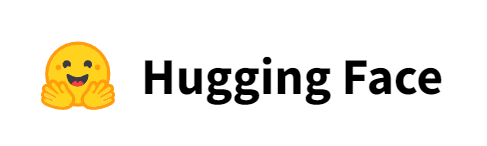

# What is Hugging Face?

https://huggingface.co/  
Hugging Face is a platform that provides a variety of datasets and pretrained models to be used out-of-the-box with little effort.  
They also have an entire course dedicated to their platform and NLP in general: https://huggingface.co/course/chapter1/1.

# Dataset: movie-related named entities

https://huggingface.co/datasets/tner/mit_movie_trivia

Today we'll be extracting information from questions about movies (actors, genres, plot descriptions, etc.)

In [ ]:
from datasets import load_dataset
datasets = load_dataset('tner/mit_movie_trivia')

# ignore this, we're renaming columns to follow common style
datasets = datasets.rename_column("tags", "ner_tags")

In [ ]:
# get all token names
import urllib.request, json 
with urllib.request.urlopen('https://huggingface.co/datasets/tner/mit_movie_trivia/raw/main/dataset/label.json') as url:
    labels_to_id = json.load(url)

# make inverse of our dictionary to do reverse lookups if we need them
id_to_labels = {v: k for k, v in labels_to_id.items()}

# this is just pretty printing:
pd.DataFrame.from_dict(labels_to_id, orient="index", columns=["ID"])

In [ ]:
# Test sentence from dataset (it is already tokenized!):
test_tokens = datasets['train'][3]

pd.DataFrame.from_dict(test_tokens, orient="index")

In this dataset, `ner_tags` field is what our NER-model will try to reconstruct given the `tokens`.

# Download the model
We've chosen BERT model to do transfer learning, which is quite popular.
https://en.wikipedia.org/wiki/BERT_(language_model)

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, pipeline

# download the model
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased",
                                                        num_labels=len(id_to_labels),
                                                        id2label=id_to_labels,
                                                        label2id=labels_to_id)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Preparing the dataset

Tokenizers are objects that prepare inputs for model. They split texts into **tokens** (words or subwords usually).  
**TODO:** play with different tokenizers here: https://huggingface.co/spaces/taka-yamakoshi/tokenizer-demo (we're using 'bert-base-uncased') and get an intuition for how tokenizers work.

Unfortunately, as you could notice, BERT uses **wordpiece tokenization** (while our dataset is **word-tokenized**).  
(more on wordpiece tokenization: https://huggingface.co/course/chapter6/6?fw=pt)

### What to do?

Well, imagine we have the following example in our dataset:  
```
[
  ('steve', 'B-Actor'),  
  ('carell', 'I-Actor')
]
```

The wordpiece tokenizer would turn `['steve', 'carell']` into `['steve', 'care', '##ll']`. So, we're missing a label for an additional token.  
*One* of the solutions is to **duplicate** labels. The result would look like this:

```
[
  ('steve', 'B-Actor'),
  ('care', 'I-Actor'),
  ('##ll', 'I-Actor')
]
```

Yes, we would duplicate `B`-tokens as well if needed.

```
[
  ('why', 'O'),
  ('does', 'O'),
  ('care', 'B-Actor'),
  ('#ll', 'B-Actor'),
  #...
]
```

In [ ]:
# This is the function that implements the solution above.

def tokenize_adjust_labels(sample):
  tokenized_samples = tokenizer.encode_plus(sample["tokens"], is_split_into_words=True)
  labels = []
  existing_label_ids = sample["ner_tags"]
  
  i = -1
  prev_wid = -1
  for wid in tokenized_samples.word_ids():
    if (wid is None):
      labels.append(-100)
    elif (wid != prev_wid):
      i = i + 1
      labels.append(existing_label_ids[i])
      prev_wid = wid
    else:
      labels.append(existing_label_ids[i])
        
  tokenized_samples["labels"] = labels
  return tokenized_samples

In [ ]:
# the 'map' function is very useful. use whenever you need to transform the dataset!
tokenized_datasets = datasets.map(tokenize_adjust_labels, remove_columns=["tokens", "ner_tags"])

# Metrics: accuracy

There are several metrics commonly used in NER tasks to evaluate how good your model is.  
You already know what one of them is — it's the **accuracy**.  

\begin{align}
        Accuracy = \frac{Correct \, predictions }{All \, predictions}
    \end{align}

It won't hurt to implement it once again :3.

In [ ]:
# [!] TODO: implement accuracy metric

def accuracy(predictions, labels):
  """
  Parameters
  ----------
  predictions: list of lists
    predictions of your model for N sentences (entire batch), i.e. something like
    [['O', 'O', 'B-YEAR'], ['B-Actor', 'I-Actor', 'O']]
  labels: list of lists
    the ground truth labels in the same format as predictions, i.e. something like
    [['O', 'O', 'B-YEAR'], ['B-Actor', 'I-Actor', 'B-YEAR']]

  Returns
  ----------
  accuracy: float
    single number between 0 and 1 that represents the accuracy
  """
  ... # TODO

In [ ]:
# test your implementation
assert(accuracy([['O', 'TOKEN']], [['O', 'TOKEN']]) == 1.)
assert(accuracy([['O', 'TOKEN', 'O'], ['O']], [['O', 'TOKEN', 'TOKEN'], ['TOKEN']]) == .5)

# Metrics: precision and recall

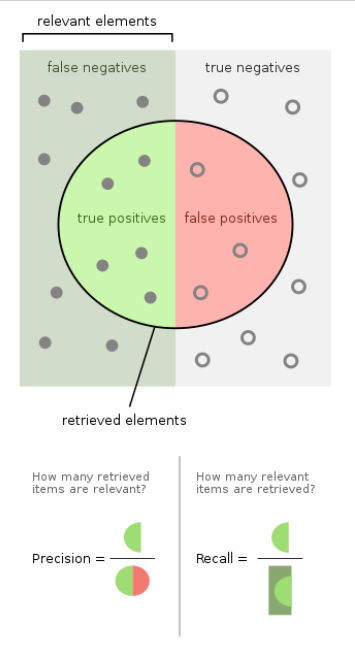

The diagram is taken from https://en.wikipedia.org/wiki/Precision_and_recall.

Let's assume you model made a prediction, trying to find all `Year` tokens in text.  
The dots in the big circle is what your model thought is a year. **True positives** are where the model was right, and **false positives** are where it was wrong.  
Now **false negatives** are what actually **is** a year but your model didn't recognize it as such, and true negatives are what isn't a year and your model was right in not recognizing it as a year.

Using these concepts, precision and recall help us extract more information about model behaviour than accuracy.

### To understand how they work, consider this:  


*   If you have high precision and low recall, your model is bad at identifying all tokens of your interest, but it is very confident in those it finds.
*   If you have low precision and high recall, your model identifies as many tokens as possible but not all of them are actually what you're looking for.



In [ ]:
# [!] TODO: implement precision for ONE class

def precision(predictions, labels, cls):
  ... # TODO

In [ ]:
# test your implementation

assert(precision([['O', 'TOKEN']], [['O', 'TOKEN']], 'TOKEN') == 1.)
assert(precision([['O', 'TOKEN', 'O'], ['O']], [['O', 'TOKEN', 'TOKEN'], ['TOKEN']], 'TOKEN') == 1.)
assert(precision([['O', 'TOKEN', 'O'], ['TOKEN']], [['O', 'TOKEN', 'O'], ['O']], 'TOKEN') == 0.5)

In [ ]:
# [!] TODO: implement recall for ONE class

def recall(predictions, labels, cls):
  ... # TODO

In [ ]:
# test your implementation

assert(recall([['O', 'TOKEN']], [['O', 'TOKEN']], 'TOKEN') == 1.)
assert(recall([['O', 'TOKEN', 'O'], ['O']], [['O', 'TOKEN', 'O'], ['TOKEN']], 'TOKEN') == 0.5)
assert(recall([['O', 'TOKEN', 'O'], ['O']], [['TOKEN', 'TOKEN', 'TOKEN'], ['TOKEN']], 'TOKEN') == 0.25)

# Metrics: F-score

F-score is a metric that combines both precision and recall and values them equally.

\begin{align}
        F_1 = 2\frac{precision*recall}{precision+recall}
\end{align}

It's also insanely popular.  
https://en.wikipedia.org/wiki/F-score

# Let's use all the metrics!

Sorry, we won't be using your precision and recall implementations. Do you remember that we're using IOB2 format? It's common to convert `B` and `I` tokens to entities before calculating precision and recall (in other words, moving from **token level** to **entity level**). This is out of today's notebook scope. We'll just use a library instead.

However, you can read more about that here:
https://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove padding
    true_predictions = [
        [id_to_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id_to_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

In [ ]:
# start our beloved tensorboard
output_dir = "movies"
%load_ext tensorboard
%tensorboard --logdir '{output_dir}'/runs

In [ ]:
from transformers import DataCollatorForTokenClassification

# this adds padding so that every sentence is the same length in tokens
data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir=output_dir, 
    evaluation_strategy="steps",
    num_train_epochs=3,
    logging_steps=500,
    report_to="tensorboard")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
trainer.evaluate(tokenized_datasets["test"])

## Look at how the model performs

This should print the entities our model has recognized.

In [ ]:
nlp = pipeline("ner", model=model.to('cpu'), tokenizer=tokenizer, aggregation_strategy="simple")

pd.DataFrame.from_dict(nlp("Did Ryan Gosling survive in Drive?"))

In [ ]:
# you can type different questions about movies to see if the model works OK.
print("Enter your question:")
text = input()
pd.DataFrame.from_dict(nlp(text))

# Home task

1. Learn how to save and reuse huggingface models either with `trainer.save_model("path")` or `trainer.push_to_hub("your_username/model")`. More on how to do that here: https://huggingface.co/docs/transformers/model_sharing.
Ideally, you need to learn how to resume training between sessions.
2. Experiment with different NER models from https://huggingface.co/models?pipeline_tag=token-classification&sort=downloads. You may need to transform our dataset significantly if a model needs that, so choose wisely. Look for instructions on each model's page.
3. Try to achieve highest metrics on whatever model you choose. Don't forget to choose the number of epochs accordingly.

